# This notebook includes extra experiments in our discussion for your reference.

In [26]:
import numpy as np
import pandas as pd
import math
from collections import Counter
import matplotlib.pyplot as plt

# <font color=#FF0000> Transformer Bert (Average sequence output)</font> 	

In [27]:
train_data = pd.read_csv('train.csv')
train_label = pd.read_csv('training-label.csv')
train_data

,mac_hash,sniffer_loc,created_time
0,0003ae8541d0e925fcee242287e2ad27,11,2018-12-07 16:48:08
1,00078611037990f7f36b722f22595fe7,3,2018-12-07 16:29:35
2,00078611037990f7f36b722f22595fe7,2,2018-12-07 16:30:41
3,00078611037990f7f36b722f22595fe7,4,2018-12-07 16:37:06
4,00078611037990f7f36b722f22595fe7,8,2018-12-07 16:37:07
...,...,...,...
41635,fff2ca0333532d6348d5b4fa39028dd4,3,2018-12-07 18:37:37
41636,fff2ca0333532d6348d5b4fa39028dd4,13,2018-12-07 18:47:53
41637,fff2ca0333532d6348d5b4fa39028dd4,12,2018-12-07 18:47:53
41638,fff2ca0333532d6348d5b4fa39028dd4,11,2018-12-07 18:47:54


In [28]:
id_list = train_label['mac_hash']
label_list = train_label['label']

id_dict = {m: [] for m in id_list}

id_dict_pad_after = {m: [] for m in id_list}
id_dict_pad_same = {m: [] for m in id_list}

# label_dict
label_dict = dict()

for i, val in enumerate(id_list):
    label_dict[val] = int(label_list[i])

for data in list(train_data.values):
    loc = data[1]
    id_dict[data[0]].append(loc)
    id_dict_pad_after[data[0]].append(loc)
    id_dict_pad_same[data[0]].append(loc)

for k, v in id_dict.items():
    if len(v) != 14:
        id_dict[k] = [0] * (14 - len(v)) + v
    id_dict[k].append(label_dict[k])
    
for k, v in id_dict_pad_after.items():
    if len(v) != 14:
        id_dict_pad_after[k] = v + [0] * (14 - len(v))
    id_dict_pad_after[k].append(label_dict[k])

for k, v in id_dict_pad_same.items():
    if len(v) != 14:
        id_dict_pad_same[k] = [int(v[0])] * (14 - len(v)) + v
    id_dict_pad_same[k].append(label_dict[k])

# original padding
data = np.array(list(id_dict.values()))
X_train = data[:,:-1]
y_train = data[:,-1]
y_train = np.eye(5)[y_train]

In [29]:
from transformers import TFBertModel, BertConfig
import tensorflow as tf

config = BertConfig(vocab_size=15, hidden_size=16, num_hidden_layer=8, num_attention_heads=4,
                    intermediate_size=64, max_position_embeddings=14)
bert = TFBertModel(config)

input_seq = tf.keras.layers.Input(shape=(14,), name='input_seq', dtype='int32')
mask = tf.keras.layers.Input(shape=(14,), name='attention_mask', dtype='int32')

encoder = bert(input_seq, attention_mask=mask)[0]
emb_avg = tf.keras.layers.AveragePooling1D(pool_size=14)(encoder)
emb_avg = tf.keras.layers.Reshape((emb_avg.shape[2],), input_shape=(1,emb_avg.shape[2]))(emb_avg)

x = tf.keras.layers.Dense(32, activation='relu')(emb_avg)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

model = tf.keras.Model(inputs=[input_seq, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

X_mask = np.ones((len(X_train),14))
history = model.fit([X_train, X_mask], y_train, batch_size=1024, epochs=500, validation_split=0.1)

Epoch 1/500
7/7 [==============================] - 12s 335ms/step - loss: 1.4699 - accuracy: 0.4209 - val_loss: 1.2915 - val_accuracy: 0.5934
Epoch 2/500
7/7 [==============================] - 0s 54ms/step - loss: 1.2421 - accuracy: 0.6064 - val_loss: 1.0809 - val_accuracy: 0.6293
Epoch 3/500
7/7 [==============================] - 0s 53ms/step - loss: 1.0616 - accuracy: 0.6158 - val_loss: 0.9692 - val_accuracy: 0.6293
Epoch 4/500
7/7 [==============================] - 0s 54ms/step - loss: 0.9613 - accuracy: 0.6184 - val_loss: 0.8865 - val_accuracy: 0.6480
Epoch 5/500
7/7 [==============================] - 0s 53ms/step - loss: 0.8750 - accuracy: 0.6657 - val_loss: 0.8149 - val_accuracy: 0.7011
Epoch 6/500
7/7 [==============================] - 0s 53ms/step - loss: 0.8033 - accuracy: 0.7083 - val_loss: 0.7384 - val_accuracy: 0.7198
Epoch 7/500
7/7 [==============================] - 0s 53ms/step - loss: 0.7329 - accuracy: 0.7156 - val_loss: 0.6742 - val_accuracy: 0.7241
Epoch 8/500
7/7 [=

Epoch 57/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0803 - accuracy: 0.9725 - val_loss: 0.0670 - val_accuracy: 0.9784
Epoch 58/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0797 - accuracy: 0.9727 - val_loss: 0.0667 - val_accuracy: 0.9784
Epoch 59/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0731 - accuracy: 0.9760 - val_loss: 0.0635 - val_accuracy: 0.9799
Epoch 60/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0767 - accuracy: 0.9751 - val_loss: 0.0643 - val_accuracy: 0.9756
Epoch 61/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0763 - accuracy: 0.9738 - val_loss: 0.0795 - val_accuracy: 0.9670
Epoch 62/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0924 - accuracy: 0.9660 - val_loss: 0.0727 - val_accuracy: 0.9741
Epoch 63/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0884 - accuracy: 0.9690 - val_loss: 0.0704 - val_accuracy: 0.9684
Epoch 64/500


Epoch 115/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0640 - accuracy: 0.9780 - val_loss: 0.0555 - val_accuracy: 0.9784
Epoch 116/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0635 - accuracy: 0.9784 - val_loss: 0.0589 - val_accuracy: 0.9741
Epoch 117/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0594 - accuracy: 0.9808 - val_loss: 0.0472 - val_accuracy: 0.9856
Epoch 118/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0627 - accuracy: 0.9791 - val_loss: 0.0486 - val_accuracy: 0.9828
Epoch 119/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0602 - accuracy: 0.9813 - val_loss: 0.0668 - val_accuracy: 0.9698
Epoch 120/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0634 - accuracy: 0.9805 - val_loss: 0.0532 - val_accuracy: 0.9871
Epoch 121/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0648 - accuracy: 0.9796 - val_loss: 0.0723 - val_accuracy: 0.9741
Epoch 

Epoch 173/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0539 - accuracy: 0.9824 - val_loss: 0.0573 - val_accuracy: 0.9799
Epoch 174/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0595 - accuracy: 0.9812 - val_loss: 0.0785 - val_accuracy: 0.9641
Epoch 175/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0567 - accuracy: 0.9829 - val_loss: 0.0472 - val_accuracy: 0.9813
Epoch 176/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0546 - accuracy: 0.9831 - val_loss: 0.0522 - val_accuracy: 0.9756
Epoch 177/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0642 - accuracy: 0.9783 - val_loss: 0.0497 - val_accuracy: 0.9770
Epoch 178/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0533 - accuracy: 0.9831 - val_loss: 0.0697 - val_accuracy: 0.9727
Epoch 179/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0557 - accuracy: 0.9831 - val_loss: 0.0498 - val_accuracy: 0.9828
Epoch 

Epoch 231/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0445 - accuracy: 0.9863 - val_loss: 0.0344 - val_accuracy: 0.9871
Epoch 232/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0462 - accuracy: 0.9856 - val_loss: 0.0348 - val_accuracy: 0.9885
Epoch 233/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0442 - accuracy: 0.9853 - val_loss: 0.0351 - val_accuracy: 0.9856
Epoch 234/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0489 - accuracy: 0.9847 - val_loss: 0.0426 - val_accuracy: 0.9842
Epoch 235/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0505 - accuracy: 0.9831 - val_loss: 0.0616 - val_accuracy: 0.9770
Epoch 236/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0500 - accuracy: 0.9852 - val_loss: 0.0367 - val_accuracy: 0.9856
Epoch 237/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0451 - accuracy: 0.9859 - val_loss: 0.0387 - val_accuracy: 0.9828
Epoch 

Epoch 289/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0483 - accuracy: 0.9840 - val_loss: 0.0479 - val_accuracy: 0.9799
Epoch 290/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0480 - accuracy: 0.9840 - val_loss: 0.0379 - val_accuracy: 0.9856
Epoch 291/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0409 - accuracy: 0.9866 - val_loss: 0.0320 - val_accuracy: 0.9871
Epoch 292/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0396 - accuracy: 0.9885 - val_loss: 0.0458 - val_accuracy: 0.9828
Epoch 293/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0447 - accuracy: 0.9859 - val_loss: 0.0418 - val_accuracy: 0.9856
Epoch 294/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0436 - accuracy: 0.9855 - val_loss: 0.0366 - val_accuracy: 0.9856
Epoch 295/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0446 - accuracy: 0.9852 - val_loss: 0.0391 - val_accuracy: 0.9856
Epoch 

Epoch 347/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0439 - accuracy: 0.9859 - val_loss: 0.0399 - val_accuracy: 0.9871
Epoch 348/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0475 - accuracy: 0.9859 - val_loss: 0.0604 - val_accuracy: 0.9756
Epoch 349/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0438 - accuracy: 0.9863 - val_loss: 0.0482 - val_accuracy: 0.9828
Epoch 350/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0410 - accuracy: 0.9874 - val_loss: 0.0421 - val_accuracy: 0.9828
Epoch 351/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0429 - accuracy: 0.9869 - val_loss: 0.0561 - val_accuracy: 0.9828
Epoch 352/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0388 - accuracy: 0.9877 - val_loss: 0.0361 - val_accuracy: 0.9842
Epoch 353/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0391 - accuracy: 0.9883 - val_loss: 0.0383 - val_accuracy: 0.9856
Epoch 

Epoch 405/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0386 - accuracy: 0.9875 - val_loss: 0.0408 - val_accuracy: 0.9856
Epoch 406/500
7/7 [==============================] - 0s 58ms/step - loss: 0.0378 - accuracy: 0.9883 - val_loss: 0.0374 - val_accuracy: 0.9828
Epoch 407/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0395 - accuracy: 0.9867 - val_loss: 0.0411 - val_accuracy: 0.9856
Epoch 408/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0438 - accuracy: 0.9864 - val_loss: 0.0488 - val_accuracy: 0.9813
Epoch 409/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0418 - accuracy: 0.9867 - val_loss: 0.0356 - val_accuracy: 0.9871
Epoch 410/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0366 - accuracy: 0.9882 - val_loss: 0.0411 - val_accuracy: 0.9828
Epoch 411/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0398 - accuracy: 0.9875 - val_loss: 0.0324 - val_accuracy: 0.9899
Epoch 

Epoch 463/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0382 - accuracy: 0.9879 - val_loss: 0.0512 - val_accuracy: 0.9799
Epoch 464/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0383 - accuracy: 0.9891 - val_loss: 0.0469 - val_accuracy: 0.9856
Epoch 465/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0365 - accuracy: 0.9885 - val_loss: 0.0361 - val_accuracy: 0.9871
Epoch 466/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0332 - accuracy: 0.9903 - val_loss: 0.0399 - val_accuracy: 0.9856
Epoch 467/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0382 - accuracy: 0.9874 - val_loss: 0.0350 - val_accuracy: 0.9871
Epoch 468/500
7/7 [==============================] - 0s 60ms/step - loss: 0.0377 - accuracy: 0.9872 - val_loss: 0.0500 - val_accuracy: 0.9828
Epoch 469/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0382 - accuracy: 0.9880 - val_loss: 0.0520 - val_accuracy: 0.9856
Epoch 

Text(0.5, 1.0, 'Training - Loss Function')

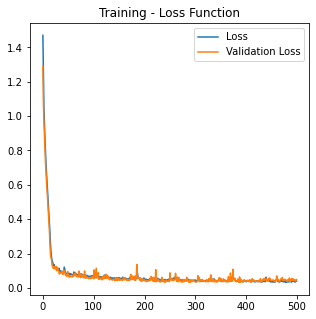

In [30]:
plt.figure(figsize=(5, 5))
plt.subplot()
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

In [31]:
test_data = pd.read_csv('test.csv')

sample = pd.read_csv('submit_samples.csv')

id_list_test = sample['mac_hash']

id_dict = {m: [] for m in id_list_test}

# label_dict
label_dict_test = dict()

for data in list(test_data.values):
    loc = data[1]
    id_dict[data[0]].append(loc)

for k, v in id_dict.items():
    if len(v) != 14:
        id_dict[k] = [0] * (14 - len(v)) + v
        
data = np.array(list(id_dict.values()))
X_test = data

X_test_mask = np.ones((len(X_test),14))

y_prob = model.predict([X_test, X_test_mask])

output = pd.DataFrame({'mac_hash':sample['mac_hash'], 'C0':y_prob[:,0], 'C1':y_prob[:,1], 'C2':y_prob[:,2], 'C3':y_prob[:,3], 'C4':y_prob[:,4]})
output.to_csv("output_transformer_bert_avg.csv", index=False)

# <font color=#FF0000> Transformer Bert (Append [CLS])</font> 	

In [32]:
id_list = train_label['mac_hash']
label_list = train_label['label']

id_dict = {m: [] for m in id_list}

# label_dict
label_dict = dict()

for i, val in enumerate(id_list):
    label_dict[val] = int(label_list[i])

for data in list(train_data.values):
    loc = data[1]
    id_dict[data[0]].append(loc)

for k, v in id_dict.items():
    if len(v) != 14:
        id_dict[k] = [101] + [0] * (14 - len(v)) + v
    else:
        id_dict[k] = [101] + v
    id_dict[k].append(label_dict[k])
    
data = np.array(list(id_dict.values()))
X_train = data[:,:-1]
y_train = data[:,-1]

y_train = np.eye(5)[y_train]

In [33]:
from transformers import TFBertModel, BertConfig
import tensorflow as tf

config = BertConfig(vocab_size=102, hidden_size=16, num_hidden_layer=8, num_attention_heads=4,
                    intermediate_size=64, max_position_embeddings=15)
bert = TFBertModel(config)

input_seq = tf.keras.layers.Input(shape=(15,), name='input_seq', dtype='int32')
mask = tf.keras.layers.Input(shape=(15,), name='attention_mask', dtype='int32')

encoder = bert(input_seq, attention_mask=mask)[0][:,0] 

x = tf.keras.layers.Dense(32, activation='relu')(encoder)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

model = tf.keras.Model(inputs=[input_seq, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

X_mask = np.concatenate((np.zeros((len(X_train),1)), np.ones((len(X_train),14))), axis=1)
history = model.fit([X_train, X_mask], y_train, batch_size=1024, epochs=500, validation_split=0.1)

Epoch 1/500
7/7 [==============================] - 12s 336ms/step - loss: 1.6473 - accuracy: 0.1934 - val_loss: 1.5020 - val_accuracy: 0.4023
Epoch 2/500
7/7 [==============================] - 0s 57ms/step - loss: 1.5130 - accuracy: 0.3840 - val_loss: 1.4535 - val_accuracy: 0.4023
Epoch 3/500
7/7 [==============================] - 0s 56ms/step - loss: 1.4548 - accuracy: 0.3883 - val_loss: 1.3694 - val_accuracy: 0.4023
Epoch 4/500
7/7 [==============================] - 0s 56ms/step - loss: 1.3427 - accuracy: 0.4915 - val_loss: 1.2215 - val_accuracy: 0.6236
Epoch 5/500
7/7 [==============================] - 0s 56ms/step - loss: 1.1929 - accuracy: 0.6050 - val_loss: 1.0900 - val_accuracy: 0.6293
Epoch 6/500
7/7 [==============================] - 0s 56ms/step - loss: 1.0577 - accuracy: 0.6190 - val_loss: 0.9571 - val_accuracy: 0.6293
Epoch 7/500
7/7 [==============================] - 0s 57ms/step - loss: 0.9466 - accuracy: 0.6307 - val_loss: 0.8627 - val_accuracy: 0.6509
Epoch 8/500
7/7 [=

Epoch 57/500
7/7 [==============================] - 0s 56ms/step - loss: 0.1134 - accuracy: 0.9617 - val_loss: 0.0844 - val_accuracy: 0.9741
Epoch 58/500
7/7 [==============================] - 0s 57ms/step - loss: 0.1020 - accuracy: 0.9676 - val_loss: 0.0862 - val_accuracy: 0.9741
Epoch 59/500
7/7 [==============================] - 0s 56ms/step - loss: 0.1025 - accuracy: 0.9647 - val_loss: 0.0930 - val_accuracy: 0.9670
Epoch 60/500
7/7 [==============================] - 0s 56ms/step - loss: 0.1000 - accuracy: 0.9677 - val_loss: 0.0820 - val_accuracy: 0.9684
Epoch 61/500
7/7 [==============================] - 0s 56ms/step - loss: 0.1025 - accuracy: 0.9655 - val_loss: 0.0866 - val_accuracy: 0.9670
Epoch 62/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0957 - accuracy: 0.9681 - val_loss: 0.0754 - val_accuracy: 0.9770
Epoch 63/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0975 - accuracy: 0.9660 - val_loss: 0.0793 - val_accuracy: 0.9756
Epoch 64/500


Epoch 115/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0721 - accuracy: 0.9757 - val_loss: 0.0616 - val_accuracy: 0.9813
Epoch 116/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0718 - accuracy: 0.9748 - val_loss: 0.0881 - val_accuracy: 0.9713
Epoch 117/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0925 - accuracy: 0.9677 - val_loss: 0.0677 - val_accuracy: 0.9813
Epoch 118/500
7/7 [==============================] - 0s 58ms/step - loss: 0.0854 - accuracy: 0.9708 - val_loss: 0.0589 - val_accuracy: 0.9799
Epoch 119/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0703 - accuracy: 0.9780 - val_loss: 0.0836 - val_accuracy: 0.9727
Epoch 120/500
7/7 [==============================] - 0s 58ms/step - loss: 0.0799 - accuracy: 0.9733 - val_loss: 0.0672 - val_accuracy: 0.9770
Epoch 121/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0720 - accuracy: 0.9756 - val_loss: 0.0592 - val_accuracy: 0.9784
Epoch 

Epoch 173/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0609 - accuracy: 0.9805 - val_loss: 0.0551 - val_accuracy: 0.9828
Epoch 174/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0620 - accuracy: 0.9808 - val_loss: 0.0615 - val_accuracy: 0.9813
Epoch 175/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0793 - accuracy: 0.9737 - val_loss: 0.0678 - val_accuracy: 0.9727
Epoch 176/500
7/7 [==============================] - 0s 62ms/step - loss: 0.0700 - accuracy: 0.9757 - val_loss: 0.0527 - val_accuracy: 0.9799
Epoch 177/500
7/7 [==============================] - 0s 60ms/step - loss: 0.0615 - accuracy: 0.9792 - val_loss: 0.0558 - val_accuracy: 0.9770
Epoch 178/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0577 - accuracy: 0.9813 - val_loss: 0.0529 - val_accuracy: 0.9813
Epoch 179/500
7/7 [==============================] - 0s 58ms/step - loss: 0.0605 - accuracy: 0.9802 - val_loss: 0.0490 - val_accuracy: 0.9813
Epoch 

Epoch 231/500
7/7 [==============================] - 0s 58ms/step - loss: 0.0601 - accuracy: 0.9802 - val_loss: 0.0472 - val_accuracy: 0.9799
Epoch 232/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0579 - accuracy: 0.9823 - val_loss: 0.0456 - val_accuracy: 0.9856
Epoch 233/500
7/7 [==============================] - 0s 63ms/step - loss: 0.0553 - accuracy: 0.9815 - val_loss: 0.0572 - val_accuracy: 0.9784
Epoch 234/500
7/7 [==============================] - 0s 60ms/step - loss: 0.0517 - accuracy: 0.9848 - val_loss: 0.0453 - val_accuracy: 0.9856
Epoch 235/500
7/7 [==============================] - 0s 61ms/step - loss: 0.0574 - accuracy: 0.9821 - val_loss: 0.0508 - val_accuracy: 0.9828
Epoch 236/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0514 - accuracy: 0.9821 - val_loss: 0.0478 - val_accuracy: 0.9828
Epoch 237/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0562 - accuracy: 0.9816 - val_loss: 0.0443 - val_accuracy: 0.9856
Epoch 

Epoch 289/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0455 - accuracy: 0.9852 - val_loss: 0.0353 - val_accuracy: 0.9871
Epoch 290/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0440 - accuracy: 0.9877 - val_loss: 0.0367 - val_accuracy: 0.9899
Epoch 291/500
7/7 [==============================] - 0s 58ms/step - loss: 0.0517 - accuracy: 0.9836 - val_loss: 0.0470 - val_accuracy: 0.9842
Epoch 292/500
7/7 [==============================] - 0s 60ms/step - loss: 0.0522 - accuracy: 0.9836 - val_loss: 0.0504 - val_accuracy: 0.9799
Epoch 293/500
7/7 [==============================] - 0s 63ms/step - loss: 0.0527 - accuracy: 0.9839 - val_loss: 0.0380 - val_accuracy: 0.9828
Epoch 294/500
7/7 [==============================] - 0s 62ms/step - loss: 0.0501 - accuracy: 0.9842 - val_loss: 0.0367 - val_accuracy: 0.9871
Epoch 295/500
7/7 [==============================] - 0s 62ms/step - loss: 0.0472 - accuracy: 0.9848 - val_loss: 0.0416 - val_accuracy: 0.9842
Epoch 

Epoch 347/500
7/7 [==============================] - 0s 60ms/step - loss: 0.0450 - accuracy: 0.9864 - val_loss: 0.0410 - val_accuracy: 0.9885
Epoch 348/500
7/7 [==============================] - 0s 58ms/step - loss: 0.0485 - accuracy: 0.9832 - val_loss: 0.0398 - val_accuracy: 0.9842
Epoch 349/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0445 - accuracy: 0.9859 - val_loss: 0.0427 - val_accuracy: 0.9813
Epoch 350/500
7/7 [==============================] - 0s 58ms/step - loss: 0.0467 - accuracy: 0.9852 - val_loss: 0.0530 - val_accuracy: 0.9799
Epoch 351/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0435 - accuracy: 0.9848 - val_loss: 0.0438 - val_accuracy: 0.9856
Epoch 352/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0415 - accuracy: 0.9880 - val_loss: 0.0385 - val_accuracy: 0.9856
Epoch 353/500
7/7 [==============================] - 0s 58ms/step - loss: 0.0410 - accuracy: 0.9880 - val_loss: 0.0439 - val_accuracy: 0.9828
Epoch 

Epoch 405/500
7/7 [==============================] - 0s 60ms/step - loss: 0.0427 - accuracy: 0.9858 - val_loss: 0.0460 - val_accuracy: 0.9799
Epoch 406/500
7/7 [==============================] - 0s 58ms/step - loss: 0.0435 - accuracy: 0.9863 - val_loss: 0.0380 - val_accuracy: 0.9842
Epoch 407/500
7/7 [==============================] - 0s 58ms/step - loss: 0.0443 - accuracy: 0.9858 - val_loss: 0.0386 - val_accuracy: 0.9856
Epoch 408/500
7/7 [==============================] - 0s 58ms/step - loss: 0.0439 - accuracy: 0.9858 - val_loss: 0.0398 - val_accuracy: 0.9842
Epoch 409/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0394 - accuracy: 0.9885 - val_loss: 0.0314 - val_accuracy: 0.9899
Epoch 410/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0404 - accuracy: 0.9871 - val_loss: 0.0490 - val_accuracy: 0.9799
Epoch 411/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0422 - accuracy: 0.9863 - val_loss: 0.0372 - val_accuracy: 0.9899
Epoch 

Epoch 463/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0426 - accuracy: 0.9875 - val_loss: 0.0533 - val_accuracy: 0.9842
Epoch 464/500
7/7 [==============================] - 0s 60ms/step - loss: 0.0448 - accuracy: 0.9852 - val_loss: 0.0357 - val_accuracy: 0.9856
Epoch 465/500
7/7 [==============================] - 0s 63ms/step - loss: 0.0455 - accuracy: 0.9856 - val_loss: 0.0503 - val_accuracy: 0.9813
Epoch 466/500
7/7 [==============================] - 0s 63ms/step - loss: 0.0434 - accuracy: 0.9859 - val_loss: 0.0362 - val_accuracy: 0.9899
Epoch 467/500
7/7 [==============================] - 0s 62ms/step - loss: 0.0433 - accuracy: 0.9852 - val_loss: 0.0434 - val_accuracy: 0.9828
Epoch 468/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0482 - accuracy: 0.9852 - val_loss: 0.0299 - val_accuracy: 0.9885
Epoch 469/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0422 - accuracy: 0.9867 - val_loss: 0.0372 - val_accuracy: 0.9871
Epoch 

Text(0.5, 1.0, 'Training - Loss Function')

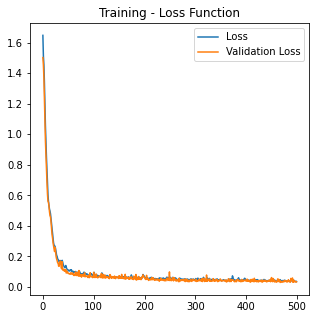

In [34]:
plt.figure(figsize=(5, 5))
plt.subplot()
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

In [35]:
test_data = pd.read_csv('test.csv')

sample = pd.read_csv('submit_samples.csv')

id_list_test = sample['mac_hash']

id_dict = {m: [] for m in id_list_test}

# label_dict
label_dict_test = dict()

for data in list(test_data.values):
    loc = data[1]
    id_dict[data[0]].append(loc)

for k, v in id_dict.items():
    if len(v) != 14:
        id_dict[k] = [101] + [0] * (14 - len(v)) + v
    else:
        id_dict[k] = [101] + v
        
data = np.array(list(id_dict.values()))
X_test = data

X_test_mask = np.concatenate((np.zeros((len(X_test),1)), np.ones((len(X_test),14))), axis=1)

y_prob = model.predict([X_test, X_test_mask])

output = pd.DataFrame({'mac_hash':sample['mac_hash'], 'C0':y_prob[:,0], 'C1':y_prob[:,1], 'C2':y_prob[:,2], 'C3':y_prob[:,3], 'C4':y_prob[:,4]})
output.to_csv("output_transformer_bert_cls.csv", index=False)

# <font color=#FF0000> Transformer Bert (Mask padded sequence)</font> 	

In [36]:
id_list = train_label['mac_hash']
label_list = train_label['label']

id_dict = {m: [] for m in id_list}

# label_dict
label_dict = dict()

X_mask = []

for i, val in enumerate(id_list):
    label_dict[val] = int(label_list[i])

for data in list(train_data.values):
    loc = data[1]
    id_dict[data[0]].append(loc)

for k, v in id_dict.items():
    if len(v) != 14:
        id_dict[k] = [0] * (14 - len(v)) + v
        X_mask.append([0] * (14 - len(v)) + [1] * len(v))
    else:
        X_mask.append([1] * 14)
    id_dict[k].append(label_dict[k])

data = np.array(list(id_dict.values()))
X_train = data[:,:-1]
y_train = data[:,-1]
X_mask = np.array(X_mask)
y_train = np.eye(5)[y_train]

In [37]:
from transformers import TFBertModel, BertConfig
import tensorflow as tf

config = BertConfig(vocab_size=15, hidden_size=16, num_hidden_layer=8, num_attention_heads=4,
                    intermediate_size=64, max_position_embeddings=14)
bert = TFBertModel(config)

input_seq = tf.keras.layers.Input(shape=(14,), name='input_seq', dtype='int32')
mask = tf.keras.layers.Input(shape=(14,), name='attention_mask', dtype='int32')

encoder = bert(input_seq, attention_mask=mask)[0][:,0] 

x = tf.keras.layers.Dense(32, activation='relu')(encoder)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

model = tf.keras.Model(inputs=[input_seq, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

history = model.fit([X_train, X_mask], y_train, batch_size=1024, epochs=500, validation_split=0.1)

Epoch 1/500
7/7 [==============================] - 12s 336ms/step - loss: 1.8405 - accuracy: 0.1581 - val_loss: 1.4698 - val_accuracy: 0.4023
Epoch 2/500
7/7 [==============================] - 0s 55ms/step - loss: 1.4447 - accuracy: 0.4300 - val_loss: 1.3126 - val_accuracy: 0.6236
Epoch 3/500
7/7 [==============================] - 0s 54ms/step - loss: 1.2567 - accuracy: 0.6021 - val_loss: 1.0869 - val_accuracy: 0.6221
Epoch 4/500
7/7 [==============================] - 0s 53ms/step - loss: 1.0485 - accuracy: 0.6229 - val_loss: 0.9437 - val_accuracy: 0.6509
Epoch 5/500
7/7 [==============================] - 0s 54ms/step - loss: 0.9294 - accuracy: 0.6455 - val_loss: 0.8493 - val_accuracy: 0.6882
Epoch 6/500
7/7 [==============================] - 0s 54ms/step - loss: 0.8394 - accuracy: 0.6773 - val_loss: 0.7739 - val_accuracy: 0.7284
Epoch 7/500
7/7 [==============================] - 0s 54ms/step - loss: 0.7738 - accuracy: 0.6947 - val_loss: 0.7145 - val_accuracy: 0.7328
Epoch 8/500
7/7 [=

Epoch 57/500
7/7 [==============================] - 0s 54ms/step - loss: 0.1016 - accuracy: 0.9642 - val_loss: 0.0803 - val_accuracy: 0.9713
Epoch 58/500
7/7 [==============================] - 0s 55ms/step - loss: 0.1054 - accuracy: 0.9636 - val_loss: 0.0773 - val_accuracy: 0.9727
Epoch 59/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0977 - accuracy: 0.9695 - val_loss: 0.0815 - val_accuracy: 0.9684
Epoch 60/500
7/7 [==============================] - 0s 56ms/step - loss: 0.1030 - accuracy: 0.9668 - val_loss: 0.0822 - val_accuracy: 0.9670
Epoch 61/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0979 - accuracy: 0.9693 - val_loss: 0.0922 - val_accuracy: 0.9713
Epoch 62/500
7/7 [==============================] - 0s 55ms/step - loss: 0.1021 - accuracy: 0.9663 - val_loss: 0.0804 - val_accuracy: 0.9698
Epoch 63/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0967 - accuracy: 0.9673 - val_loss: 0.1004 - val_accuracy: 0.9598
Epoch 64/500


Epoch 115/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0849 - accuracy: 0.9692 - val_loss: 0.0778 - val_accuracy: 0.9655
Epoch 116/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0774 - accuracy: 0.9741 - val_loss: 0.0717 - val_accuracy: 0.9741
Epoch 117/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0754 - accuracy: 0.9745 - val_loss: 0.0558 - val_accuracy: 0.9784
Epoch 118/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0758 - accuracy: 0.9746 - val_loss: 0.0636 - val_accuracy: 0.9727
Epoch 119/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0719 - accuracy: 0.9740 - val_loss: 0.0660 - val_accuracy: 0.9727
Epoch 120/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0704 - accuracy: 0.9760 - val_loss: 0.0589 - val_accuracy: 0.9813
Epoch 121/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0744 - accuracy: 0.9748 - val_loss: 0.0656 - val_accuracy: 0.9756
Epoch 

Epoch 173/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0667 - accuracy: 0.9764 - val_loss: 0.0559 - val_accuracy: 0.9770
Epoch 174/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0662 - accuracy: 0.9781 - val_loss: 0.0541 - val_accuracy: 0.9799
Epoch 175/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0665 - accuracy: 0.9786 - val_loss: 0.0610 - val_accuracy: 0.9770
Epoch 176/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0655 - accuracy: 0.9794 - val_loss: 0.0624 - val_accuracy: 0.9713
Epoch 177/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0633 - accuracy: 0.9802 - val_loss: 0.0570 - val_accuracy: 0.9770
Epoch 178/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0631 - accuracy: 0.9781 - val_loss: 0.0507 - val_accuracy: 0.9813
Epoch 179/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0636 - accuracy: 0.9778 - val_loss: 0.0462 - val_accuracy: 0.9856
Epoch 

Epoch 231/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0567 - accuracy: 0.9826 - val_loss: 0.0498 - val_accuracy: 0.9799
Epoch 232/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0598 - accuracy: 0.9800 - val_loss: 0.0530 - val_accuracy: 0.9770
Epoch 233/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0669 - accuracy: 0.9775 - val_loss: 0.0527 - val_accuracy: 0.9842
Epoch 234/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0616 - accuracy: 0.9791 - val_loss: 0.0526 - val_accuracy: 0.9799
Epoch 235/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0585 - accuracy: 0.9796 - val_loss: 0.0442 - val_accuracy: 0.9842
Epoch 236/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0571 - accuracy: 0.9792 - val_loss: 0.0446 - val_accuracy: 0.9856
Epoch 237/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0592 - accuracy: 0.9796 - val_loss: 0.0475 - val_accuracy: 0.9784
Epoch 

Epoch 289/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0504 - accuracy: 0.9829 - val_loss: 0.0637 - val_accuracy: 0.9756
Epoch 290/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0555 - accuracy: 0.9810 - val_loss: 0.0517 - val_accuracy: 0.9784
Epoch 291/500
7/7 [==============================] - 0s 61ms/step - loss: 0.0560 - accuracy: 0.9799 - val_loss: 0.0514 - val_accuracy: 0.9813
Epoch 292/500
7/7 [==============================] - 0s 60ms/step - loss: 0.0568 - accuracy: 0.9808 - val_loss: 0.0470 - val_accuracy: 0.9813
Epoch 293/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0547 - accuracy: 0.9820 - val_loss: 0.0524 - val_accuracy: 0.9842
Epoch 294/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0526 - accuracy: 0.9840 - val_loss: 0.0462 - val_accuracy: 0.9856
Epoch 295/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0566 - accuracy: 0.9813 - val_loss: 0.0701 - val_accuracy: 0.9713
Epoch 

Epoch 347/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0557 - accuracy: 0.9808 - val_loss: 0.0607 - val_accuracy: 0.9784
Epoch 348/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0516 - accuracy: 0.9837 - val_loss: 0.0508 - val_accuracy: 0.9799
Epoch 349/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0511 - accuracy: 0.9828 - val_loss: 0.0617 - val_accuracy: 0.9799
Epoch 350/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0566 - accuracy: 0.9799 - val_loss: 0.0622 - val_accuracy: 0.9813
Epoch 351/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0554 - accuracy: 0.9805 - val_loss: 0.0669 - val_accuracy: 0.9756
Epoch 352/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0542 - accuracy: 0.9812 - val_loss: 0.0590 - val_accuracy: 0.9770
Epoch 353/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0514 - accuracy: 0.9844 - val_loss: 0.0510 - val_accuracy: 0.9813
Epoch 

Epoch 405/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0534 - accuracy: 0.9816 - val_loss: 0.0512 - val_accuracy: 0.9856
Epoch 406/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0511 - accuracy: 0.9821 - val_loss: 0.0512 - val_accuracy: 0.9842
Epoch 407/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0496 - accuracy: 0.9829 - val_loss: 0.0709 - val_accuracy: 0.9698
Epoch 408/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0525 - accuracy: 0.9805 - val_loss: 0.0681 - val_accuracy: 0.9770
Epoch 409/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0523 - accuracy: 0.9818 - val_loss: 0.0440 - val_accuracy: 0.9856
Epoch 410/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0521 - accuracy: 0.9834 - val_loss: 0.0449 - val_accuracy: 0.9856
Epoch 411/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0499 - accuracy: 0.9836 - val_loss: 0.0482 - val_accuracy: 0.9828
Epoch 

Epoch 463/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0473 - accuracy: 0.9847 - val_loss: 0.0583 - val_accuracy: 0.9770
Epoch 464/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0459 - accuracy: 0.9850 - val_loss: 0.0632 - val_accuracy: 0.9727
Epoch 465/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0446 - accuracy: 0.9834 - val_loss: 0.0531 - val_accuracy: 0.9813
Epoch 466/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0426 - accuracy: 0.9866 - val_loss: 0.0552 - val_accuracy: 0.9813
Epoch 467/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0433 - accuracy: 0.9850 - val_loss: 0.0710 - val_accuracy: 0.9741
Epoch 468/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0435 - accuracy: 0.9842 - val_loss: 0.0576 - val_accuracy: 0.9741
Epoch 469/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0461 - accuracy: 0.9852 - val_loss: 0.0619 - val_accuracy: 0.9799
Epoch 

Text(0.5, 1.0, 'Training - Loss Function')

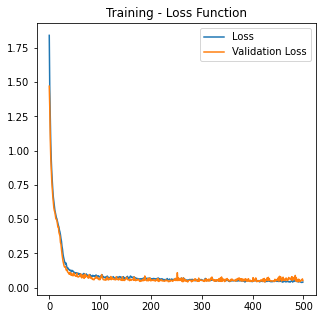

In [38]:
plt.figure(figsize=(5, 5))
plt.subplot()
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

In [39]:
test_data = pd.read_csv('test.csv')

sample = pd.read_csv('submit_samples.csv')

id_list_test = sample['mac_hash']

id_dict = {m: [] for m in id_list_test}

# label_dict
label_dict_test = dict()
X_test_mask = []

for data in list(test_data.values):
    loc = data[1]
    id_dict[data[0]].append(loc)

for k, v in id_dict.items():
    if len(v) != 14:
        id_dict[k] = [0] * (14 - len(v)) + v
        X_test_mask.append([0]*(14 - len(v))+[1]*len(v))
    else:
        X_test_mask.append([1]*14)
        
data = np.array(list(id_dict.values()))
X_test = data
X_test_mask = np.array(X_test_mask)

y_prob = model.predict([X_test, X_test_mask])

output = pd.DataFrame({'mac_hash':sample['mac_hash'], 'C0':y_prob[:,0], 'C1':y_prob[:,1], 'C2':y_prob[:,2], 'C3':y_prob[:,3], 'C4':y_prob[:,4]})
output.to_csv("output_transformer_bert_mask.csv", index=False)

# <font color=#FF0000> Transformer Bert (with padding 0's after the sequence)</font>

In [40]:
id_list = train_label['mac_hash']
label_list = train_label['label']

id_dict = {m: [] for m in id_list}

id_dict_pad_after = {m: [] for m in id_list}
id_dict_pad_same = {m: [] for m in id_list}

# label_dict
label_dict = dict()

for i, val in enumerate(id_list):
    label_dict[val] = int(label_list[i])

for data in list(train_data.values):
    loc = data[1]
    id_dict[data[0]].append(loc)
    id_dict_pad_after[data[0]].append(loc)
    id_dict_pad_same[data[0]].append(loc)

for k, v in id_dict.items():
    if len(v) != 14:
        id_dict[k] = [0] * (14 - len(v)) + v
    id_dict[k].append(label_dict[k])
    
for k, v in id_dict_pad_after.items():
    if len(v) != 14:
        id_dict_pad_after[k] = v + [0] * (14 - len(v))
    id_dict_pad_after[k].append(label_dict[k])

for k, v in id_dict_pad_same.items():
    if len(v) != 14:
        id_dict_pad_same[k] = [int(v[0])] * (14 - len(v)) + v
    id_dict_pad_same[k].append(label_dict[k])

In [41]:
data = np.array(list(id_dict_pad_after.values()))
X_train = data[:,:-1]
y_train = data[:,-1]
y_train = np.eye(5)[y_train]

config = BertConfig(vocab_size=15, hidden_size=16, num_hidden_layer=8, num_attention_heads=4,
                    intermediate_size=64, max_position_embeddings=14)
bert = TFBertModel(config)

input_seq = tf.keras.layers.Input(shape=(14,), name='input_seq', dtype='int32')
mask = tf.keras.layers.Input(shape=(14,), name='attention_mask', dtype='int32')

#embeddings = bert(input_seq, attention_mask=mask)[1]
embeddings = bert(input_seq, attention_mask=mask)[1] 

x = tf.keras.layers.Dense(32, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

model = tf.keras.Model(inputs=[input_seq, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

X_mask = np.ones((len(X_train),14))
history = model.fit([X_train, X_mask], y_train, batch_size=1024, epochs=500, validation_split=0.1)
# y_train

Epoch 1/500
7/7 [==============================] - 12s 333ms/step - loss: 1.5970 - accuracy: 0.2603 - val_loss: 1.5569 - val_accuracy: 0.4023
Epoch 2/500
7/7 [==============================] - 0s 54ms/step - loss: 1.5451 - accuracy: 0.3880 - val_loss: 1.5106 - val_accuracy: 0.4023
Epoch 3/500
7/7 [==============================] - 0s 54ms/step - loss: 1.5053 - accuracy: 0.3880 - val_loss: 1.4684 - val_accuracy: 0.4023
Epoch 4/500
7/7 [==============================] - 0s 54ms/step - loss: 1.4506 - accuracy: 0.4472 - val_loss: 1.3693 - val_accuracy: 0.6236
Epoch 5/500
7/7 [==============================] - 0s 54ms/step - loss: 1.3207 - accuracy: 0.6117 - val_loss: 1.2174 - val_accuracy: 0.6250
Epoch 6/500
7/7 [==============================] - 0s 54ms/step - loss: 1.1715 - accuracy: 0.6118 - val_loss: 1.0972 - val_accuracy: 0.6236
Epoch 7/500
7/7 [==============================] - 0s 54ms/step - loss: 1.0583 - accuracy: 0.6130 - val_loss: 0.9897 - val_accuracy: 0.6236
Epoch 8/500
7/7 [=

7/7 [==============================] - 0s 58ms/step - loss: 0.0800 - accuracy: 0.9730 - val_loss: 0.0490 - val_accuracy: 0.9856
Epoch 118/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0783 - accuracy: 0.9730 - val_loss: 0.0458 - val_accuracy: 0.9856
Epoch 119/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0704 - accuracy: 0.9762 - val_loss: 0.0514 - val_accuracy: 0.9813
Epoch 120/500
7/7 [==============================] - 0s 62ms/step - loss: 0.0682 - accuracy: 0.9776 - val_loss: 0.0603 - val_accuracy: 0.9799
Epoch 121/500
7/7 [==============================] - 0s 58ms/step - loss: 0.0736 - accuracy: 0.9757 - val_loss: 0.0668 - val_accuracy: 0.9784
Epoch 122/500
7/7 [==============================] - 0s 58ms/step - loss: 0.0766 - accuracy: 0.9732 - val_loss: 0.0659 - val_accuracy: 0.9799
Epoch 123/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0837 - accuracy: 0.9701 - val_loss: 0.0533 - val_accuracy: 0.9828
Epoch 124/500
7/7 [=

Epoch 175/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0558 - accuracy: 0.9813 - val_loss: 0.0502 - val_accuracy: 0.9828
Epoch 176/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0607 - accuracy: 0.9788 - val_loss: 0.0484 - val_accuracy: 0.9828
Epoch 177/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0597 - accuracy: 0.9807 - val_loss: 0.0476 - val_accuracy: 0.9784
Epoch 178/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0618 - accuracy: 0.9791 - val_loss: 0.0483 - val_accuracy: 0.9871
Epoch 179/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0588 - accuracy: 0.9797 - val_loss: 0.0485 - val_accuracy: 0.9799
Epoch 180/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0610 - accuracy: 0.9789 - val_loss: 0.0410 - val_accuracy: 0.9842
Epoch 181/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0582 - accuracy: 0.9796 - val_loss: 0.0476 - val_accuracy: 0.9813
Epoch 

Epoch 233/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0544 - accuracy: 0.9823 - val_loss: 0.0480 - val_accuracy: 0.9856
Epoch 234/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0577 - accuracy: 0.9812 - val_loss: 0.0477 - val_accuracy: 0.9856
Epoch 235/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0606 - accuracy: 0.9792 - val_loss: 0.0607 - val_accuracy: 0.9770
Epoch 236/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0631 - accuracy: 0.9784 - val_loss: 0.0449 - val_accuracy: 0.9842
Epoch 237/500
7/7 [==============================] - 0s 61ms/step - loss: 0.0539 - accuracy: 0.9826 - val_loss: 0.0519 - val_accuracy: 0.9828
Epoch 238/500
7/7 [==============================] - 0s 61ms/step - loss: 0.0512 - accuracy: 0.9826 - val_loss: 0.0463 - val_accuracy: 0.9842
Epoch 239/500
7/7 [==============================] - 0s 58ms/step - loss: 0.0514 - accuracy: 0.9829 - val_loss: 0.0424 - val_accuracy: 0.9842
Epoch 

Epoch 291/500
7/7 [==============================] - 0s 61ms/step - loss: 0.0564 - accuracy: 0.9820 - val_loss: 0.0382 - val_accuracy: 0.9856
Epoch 292/500
7/7 [==============================] - 0s 58ms/step - loss: 0.0531 - accuracy: 0.9810 - val_loss: 0.0392 - val_accuracy: 0.9871
Epoch 293/500
7/7 [==============================] - 0s 61ms/step - loss: 0.0480 - accuracy: 0.9831 - val_loss: 0.0417 - val_accuracy: 0.9871
Epoch 294/500
7/7 [==============================] - 0s 61ms/step - loss: 0.0508 - accuracy: 0.9829 - val_loss: 0.0484 - val_accuracy: 0.9842
Epoch 295/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0526 - accuracy: 0.9828 - val_loss: 0.0451 - val_accuracy: 0.9842
Epoch 296/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0527 - accuracy: 0.9826 - val_loss: 0.0401 - val_accuracy: 0.9842
Epoch 297/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0488 - accuracy: 0.9839 - val_loss: 0.0321 - val_accuracy: 0.9914
Epoch 

Epoch 349/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0442 - accuracy: 0.9853 - val_loss: 0.0299 - val_accuracy: 0.9885
Epoch 350/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0421 - accuracy: 0.9864 - val_loss: 0.0372 - val_accuracy: 0.9842
Epoch 351/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0476 - accuracy: 0.9848 - val_loss: 0.0498 - val_accuracy: 0.9813
Epoch 352/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0506 - accuracy: 0.9836 - val_loss: 0.0488 - val_accuracy: 0.9799
Epoch 353/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0467 - accuracy: 0.9842 - val_loss: 0.0396 - val_accuracy: 0.9842
Epoch 354/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0514 - accuracy: 0.9840 - val_loss: 0.0559 - val_accuracy: 0.9799
Epoch 355/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0518 - accuracy: 0.9839 - val_loss: 0.0405 - val_accuracy: 0.9828
Epoch 

Epoch 407/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0395 - accuracy: 0.9882 - val_loss: 0.0305 - val_accuracy: 0.9899
Epoch 408/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0373 - accuracy: 0.9880 - val_loss: 0.0478 - val_accuracy: 0.9813
Epoch 409/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0441 - accuracy: 0.9864 - val_loss: 0.0329 - val_accuracy: 0.9885
Epoch 410/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0386 - accuracy: 0.9874 - val_loss: 0.0356 - val_accuracy: 0.9856
Epoch 411/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0388 - accuracy: 0.9864 - val_loss: 0.0319 - val_accuracy: 0.9899
Epoch 412/500
7/7 [==============================] - 0s 58ms/step - loss: 0.0418 - accuracy: 0.9858 - val_loss: 0.0363 - val_accuracy: 0.9856
Epoch 413/500
7/7 [==============================] - 0s 58ms/step - loss: 0.0380 - accuracy: 0.9883 - val_loss: 0.0333 - val_accuracy: 0.9871
Epoch 

Epoch 465/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0370 - accuracy: 0.9891 - val_loss: 0.0390 - val_accuracy: 0.9885
Epoch 466/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0368 - accuracy: 0.9883 - val_loss: 0.0304 - val_accuracy: 0.9899
Epoch 467/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0363 - accuracy: 0.9883 - val_loss: 0.0324 - val_accuracy: 0.9885
Epoch 468/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0349 - accuracy: 0.9888 - val_loss: 0.0435 - val_accuracy: 0.9842
Epoch 469/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0404 - accuracy: 0.9880 - val_loss: 0.0342 - val_accuracy: 0.9871
Epoch 470/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0381 - accuracy: 0.9885 - val_loss: 0.0315 - val_accuracy: 0.9842
Epoch 471/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0372 - accuracy: 0.9885 - val_loss: 0.0339 - val_accuracy: 0.9899
Epoch 

Text(0.5, 1.0, 'Training - Loss Function')

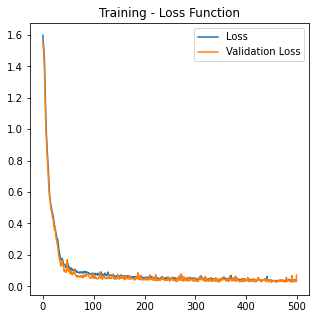

In [42]:
plt.figure(figsize=(5, 5))
plt.subplot()
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

In [43]:
sample = pd.read_csv('submit_samples.csv')
# sample
test_id_list = sample['mac_hash']

test_id_dict = {m: [] for m in test_id_list}

# label_dict
label_dict = dict()

for data in list(test_data.values):
    loc = data[1]
    test_id_dict[data[0]].append(loc)

for k, v in test_id_dict.items():
    if len(v) != 14:
        # test_id_dict[k] = [0] * (14 - len(v)) + v
        test_id_dict[k] = v + [0] * (14 - len(v))

data = np.array(list(test_id_dict.values()))
X_test = data
X_test_mask = np.ones((len(X_test),14))

y_prob = model.predict([X_test, X_test_mask])
# y_prob

output = pd.DataFrame({'mac_hash':sample['mac_hash'], 'C0':y_prob[:,0], 'C1':y_prob[:,1], 'C2':y_prob[:,2], 'C3':y_prob[:,3], 'C4':y_prob[:,4]})
output.to_csv("output_transformer_bert_pad_after.csv", index=False)


# <font color=#FF0000> Transformer Bert (with padding the same value of the head)</font>

In [44]:
data = np.array(list(id_dict_pad_same.values()))
X_train = data[:,:-1]
y_train = data[:,-1]
y_train = np.eye(5)[y_train]

config = BertConfig(vocab_size=15, hidden_size=16, num_hidden_layer=8, num_attention_heads=4,
                    intermediate_size=64, max_position_embeddings=14)
bert = TFBertModel(config)

input_seq = tf.keras.layers.Input(shape=(14,), name='input_seq', dtype='int32')
mask = tf.keras.layers.Input(shape=(14,), name='attention_mask', dtype='int32')

#embeddings = bert(input_seq, attention_mask=mask)[1]
embeddings = bert(input_seq, attention_mask=mask)[1] 

x = tf.keras.layers.Dense(32, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

model = tf.keras.Model(inputs=[input_seq, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

X_mask = np.ones((len(X_train),14))
history = model.fit([X_train, X_mask], y_train, batch_size=1024, epochs=500, validation_split=0.1)

Epoch 1/500
7/7 [==============================] - 12s 332ms/step - loss: 1.5911 - accuracy: 0.3005 - val_loss: 1.5516 - val_accuracy: 0.4023
Epoch 2/500
7/7 [==============================] - 0s 55ms/step - loss: 1.5423 - accuracy: 0.3880 - val_loss: 1.5114 - val_accuracy: 0.4023
Epoch 3/500
7/7 [==============================] - 0s 54ms/step - loss: 1.5090 - accuracy: 0.3880 - val_loss: 1.4811 - val_accuracy: 0.4023
Epoch 4/500
7/7 [==============================] - 0s 54ms/step - loss: 1.4880 - accuracy: 0.3880 - val_loss: 1.4582 - val_accuracy: 0.4023
Epoch 5/500
7/7 [==============================] - 0s 54ms/step - loss: 1.4620 - accuracy: 0.3923 - val_loss: 1.4317 - val_accuracy: 0.4368
Epoch 6/500
7/7 [==============================] - 0s 54ms/step - loss: 1.4354 - accuracy: 0.4309 - val_loss: 1.4124 - val_accuracy: 0.4325
Epoch 7/500
7/7 [==============================] - 0s 54ms/step - loss: 1.4104 - accuracy: 0.4343 - val_loss: 1.3794 - val_accuracy: 0.4325
Epoch 8/500
7/7 [=

7/7 [==============================] - 0s 61ms/step - loss: 0.2751 - accuracy: 0.9047 - val_loss: 0.2321 - val_accuracy: 0.9181
Epoch 118/500
7/7 [==============================] - 0s 61ms/step - loss: 0.2851 - accuracy: 0.8949 - val_loss: 0.2357 - val_accuracy: 0.9167
Epoch 119/500
7/7 [==============================] - 0s 58ms/step - loss: 0.2653 - accuracy: 0.9045 - val_loss: 0.2535 - val_accuracy: 0.9052
Epoch 120/500
7/7 [==============================] - 0s 57ms/step - loss: 0.2637 - accuracy: 0.9074 - val_loss: 0.2507 - val_accuracy: 0.9023
Epoch 121/500
7/7 [==============================] - 0s 55ms/step - loss: 0.2710 - accuracy: 0.9044 - val_loss: 0.2367 - val_accuracy: 0.9138
Epoch 122/500
7/7 [==============================] - 0s 55ms/step - loss: 0.2575 - accuracy: 0.9090 - val_loss: 0.2336 - val_accuracy: 0.9095
Epoch 123/500
7/7 [==============================] - 0s 60ms/step - loss: 0.2633 - accuracy: 0.9072 - val_loss: 0.2329 - val_accuracy: 0.9080
Epoch 124/500
7/7 [=

Epoch 175/500
7/7 [==============================] - 0s 56ms/step - loss: 0.1580 - accuracy: 0.9448 - val_loss: 0.1647 - val_accuracy: 0.9325
Epoch 176/500
7/7 [==============================] - 0s 55ms/step - loss: 0.1536 - accuracy: 0.9443 - val_loss: 0.1625 - val_accuracy: 0.9353
Epoch 177/500
7/7 [==============================] - 0s 54ms/step - loss: 0.1625 - accuracy: 0.9398 - val_loss: 0.1685 - val_accuracy: 0.9310
Epoch 178/500
7/7 [==============================] - 0s 55ms/step - loss: 0.1658 - accuracy: 0.9420 - val_loss: 0.1733 - val_accuracy: 0.9267
Epoch 179/500
7/7 [==============================] - 0s 55ms/step - loss: 0.1617 - accuracy: 0.9465 - val_loss: 0.1655 - val_accuracy: 0.9368
Epoch 180/500
7/7 [==============================] - 0s 55ms/step - loss: 0.1604 - accuracy: 0.9448 - val_loss: 0.1688 - val_accuracy: 0.9397
Epoch 181/500
7/7 [==============================] - 0s 56ms/step - loss: 0.1614 - accuracy: 0.9416 - val_loss: 0.1560 - val_accuracy: 0.9411
Epoch 

Epoch 233/500
7/7 [==============================] - 0s 60ms/step - loss: 0.1212 - accuracy: 0.9590 - val_loss: 0.1395 - val_accuracy: 0.9483
Epoch 234/500
7/7 [==============================] - 0s 58ms/step - loss: 0.1266 - accuracy: 0.9577 - val_loss: 0.1347 - val_accuracy: 0.9454
Epoch 235/500
7/7 [==============================] - 0s 56ms/step - loss: 0.1193 - accuracy: 0.9588 - val_loss: 0.1433 - val_accuracy: 0.9483
Epoch 236/500
7/7 [==============================] - 0s 55ms/step - loss: 0.1284 - accuracy: 0.9535 - val_loss: 0.1431 - val_accuracy: 0.9483
Epoch 237/500
7/7 [==============================] - 0s 55ms/step - loss: 0.1245 - accuracy: 0.9534 - val_loss: 0.1487 - val_accuracy: 0.9425
Epoch 238/500
7/7 [==============================] - 0s 55ms/step - loss: 0.1257 - accuracy: 0.9586 - val_loss: 0.1278 - val_accuracy: 0.9497
Epoch 239/500
7/7 [==============================] - 0s 55ms/step - loss: 0.1222 - accuracy: 0.9580 - val_loss: 0.1143 - val_accuracy: 0.9583
Epoch 

Epoch 291/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0995 - accuracy: 0.9652 - val_loss: 0.1032 - val_accuracy: 0.9598
Epoch 292/500
7/7 [==============================] - 0s 57ms/step - loss: 0.1054 - accuracy: 0.9633 - val_loss: 0.1060 - val_accuracy: 0.9612
Epoch 293/500
7/7 [==============================] - 0s 58ms/step - loss: 0.0979 - accuracy: 0.9698 - val_loss: 0.1016 - val_accuracy: 0.9626
Epoch 294/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0989 - accuracy: 0.9665 - val_loss: 0.1085 - val_accuracy: 0.9626
Epoch 295/500
7/7 [==============================] - 0s 57ms/step - loss: 0.1021 - accuracy: 0.9657 - val_loss: 0.1109 - val_accuracy: 0.9569
Epoch 296/500
7/7 [==============================] - 0s 56ms/step - loss: 0.1007 - accuracy: 0.9660 - val_loss: 0.1028 - val_accuracy: 0.9641
Epoch 297/500
7/7 [==============================] - 0s 58ms/step - loss: 0.1015 - accuracy: 0.9671 - val_loss: 0.1017 - val_accuracy: 0.9684
Epoch 

Epoch 349/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0980 - accuracy: 0.9652 - val_loss: 0.0925 - val_accuracy: 0.9655
Epoch 350/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0923 - accuracy: 0.9673 - val_loss: 0.0983 - val_accuracy: 0.9684
Epoch 351/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0885 - accuracy: 0.9677 - val_loss: 0.0985 - val_accuracy: 0.9684
Epoch 352/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0931 - accuracy: 0.9662 - val_loss: 0.1137 - val_accuracy: 0.9626
Epoch 353/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0937 - accuracy: 0.9669 - val_loss: 0.0960 - val_accuracy: 0.9727
Epoch 354/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0836 - accuracy: 0.9713 - val_loss: 0.1032 - val_accuracy: 0.9670
Epoch 355/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0969 - accuracy: 0.9650 - val_loss: 0.1126 - val_accuracy: 0.9569
Epoch 

Epoch 407/500
7/7 [==============================] - 0s 59ms/step - loss: 0.0798 - accuracy: 0.9727 - val_loss: 0.0936 - val_accuracy: 0.9684
Epoch 408/500
7/7 [==============================] - 0s 58ms/step - loss: 0.0783 - accuracy: 0.9725 - val_loss: 0.0977 - val_accuracy: 0.9655
Epoch 409/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0815 - accuracy: 0.9730 - val_loss: 0.0907 - val_accuracy: 0.9655
Epoch 410/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0818 - accuracy: 0.9721 - val_loss: 0.1052 - val_accuracy: 0.9612
Epoch 411/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0762 - accuracy: 0.9749 - val_loss: 0.1018 - val_accuracy: 0.9670
Epoch 412/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0783 - accuracy: 0.9743 - val_loss: 0.1122 - val_accuracy: 0.9612
Epoch 413/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0836 - accuracy: 0.9698 - val_loss: 0.1141 - val_accuracy: 0.9612
Epoch 

Epoch 465/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0711 - accuracy: 0.9751 - val_loss: 0.0905 - val_accuracy: 0.9713
Epoch 466/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0687 - accuracy: 0.9781 - val_loss: 0.1179 - val_accuracy: 0.9626
Epoch 467/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0662 - accuracy: 0.9780 - val_loss: 0.0943 - val_accuracy: 0.9655
Epoch 468/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0637 - accuracy: 0.9781 - val_loss: 0.0968 - val_accuracy: 0.9698
Epoch 469/500
7/7 [==============================] - 0s 55ms/step - loss: 0.0643 - accuracy: 0.9778 - val_loss: 0.0848 - val_accuracy: 0.9684
Epoch 470/500
7/7 [==============================] - 0s 54ms/step - loss: 0.0691 - accuracy: 0.9786 - val_loss: 0.1097 - val_accuracy: 0.9626
Epoch 471/500
7/7 [==============================] - 0s 56ms/step - loss: 0.0711 - accuracy: 0.9757 - val_loss: 0.0942 - val_accuracy: 0.9684
Epoch 

Text(0.5, 1.0, 'Training - Loss Function')

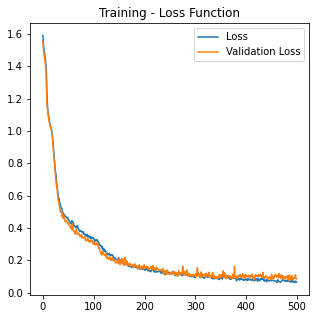

In [45]:
plt.figure(figsize=(5, 5))
plt.subplot()
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

In [46]:
sample = pd.read_csv('submit_samples.csv')
# sample
test_id_list = sample['mac_hash']

test_id_dict = {m: [] for m in test_id_list}

# label_dict
label_dict = dict()

for data in list(test_data.values):
    loc = data[1]
    test_id_dict[data[0]].append(loc)

for k, v in test_id_dict.items():
    if len(v) != 14:
        test_id_dict[k] = [int(v[0])] * (14 - len(v)) + v
data = np.array(list(test_id_dict.values()))
X_test = data
X_test_mask = np.ones((len(X_test),14))

y_prob = model.predict([X_test, X_test_mask])
# y_prob
output = pd.DataFrame({'mac_hash':sample['mac_hash'], 'C0':y_prob[:,0], 'C1':y_prob[:,1], 'C2':y_prob[:,2], 'C3':y_prob[:,3], 'C4':y_prob[:,4]})
output.to_csv("output_transformer_bert_pad_same.csv", index=False)